구내식당 관리자 A씨는 요즘 음식 재고로 인해 스트레스를 받고 있음
구내식당에 오는 사람을 감으로 예측을 하고 있었는데 어떤 날은 적게, 어떤 날은 많게 오는 경우가 허다해서 재고 관리 측면에서 손실을 크게 보고 있음

메뉴 정보 + 식수 근무자 정보 데이터를 활용해 식수를 예측하고 재고 관리를 효율적으로 하고자함.

## 문제정의
- BX : 매장의 음식 재고를 효율적으로 관리하여 손실을 최소화하고 운영 효율성을 높이자
- CX : 적정한 식수 예측 → 식사 시간대에 음식이 부족하거나 남지 않도록 하여 고객의 불만을 줄이고 만족도를 높여보자
- DX : 식수 예측과 관련된 정보를 지속적으로 확인하고 개선
    - 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 중식계, 석식계, 요일, 메뉴 정보
- Trigger : 최근 매장의 음식 재고 관리 문제로 인한 손실 발생 증가
- Accelerator : 메뉴 정보, 근무자의 정보, 중식 및 석식 식수 데이터 등
- Tracker : 식수 예측 정확도와 재고 손실 변화 추이 확인 및 분석

BX : 회사 입장에서 정리한 문제
CX : 고객 입장에서 정리한 문제
DX : 디지털 경험에서 정리한 문제

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib 관련 모듈을 추가로 import
import matplotlib.font_manager as fm
import matplotlib as mpl

In [2]:
# 한글 폰트 설정
# plt.rcParams['']
plt.rc('font', family = 'Gulim')
# plt.rcParams['font.family'] = 'Gulim'

# 한글이 표기가 안 될 때 ㅁㅁㅁㅁ xxxxxx
# 이렇게 표시 안 되도록 설정(한글 깨지는 것 방지)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기.
# encoding = 'cp949'
# cafeteria.csv 파일 불러와서 df에 저장
df = pd.read_csv("./data/Cafeteria.csv", encoding = "cp949")
# 한글 인코딩 : utf-8, euc-kr, cp949

- 데이터 정보

| 컬럼명                    | 설명                                     |
|--------------------------|----------------------------------------|
| 일자                     | 데이터가 수집된 날짜                    |
| 요일                     | 해당 날짜의 요일                        |
| 본사정원수               | 본사에 근무하는 전체 직원 수             |
| 본사휴가자수             | 본사에 휴가 중인 직원 수                |
| 본사출장자수             | 본사에 출장 중인 직원 수                |
| 본사시간외근무명령서승인건수 | 본사에서 승인된 시간 외 근무 명령서 건수  |
| 현본사소속재택근무자수   | 본사 소속 중 재택 근무 중인 직원 수     |
| 조식메뉴                 | 해당 날짜의 조식 메뉴                   |
| 중식메뉴                 | 해당 날짜의 중식 메뉴                   |
| 석식메뉴                 | 해당 날짜의 석식 메뉴                   |
| 중식계                   | 해당 날짜에 중식을 이용한 직원 수       |
| 석식계                   | 해당 날짜에 석식을 이용한 직원 수       |

In [4]:
# 데이터 정보 확인
df.info()
# 1205개의 행, 12개의 컬럼 (1205, 12)
# 결측치는 없음
# 일자, 요일, 메뉴 정보는 문자열 나머지는 수치형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [5]:
# 데이터 생플링
df.head(3)
# 일자는 년-월-일로 구성된 데이터(영어, 한글 아님)
# python에서 제공하는 날짜 자료형을 활용해 일자 컬럼을 처리해보자.

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [6]:
import datetime
# 날짜(시간) 관련된 연산, 비교같은 기능을 제공하는 모듈

In [7]:
# 1. 문자열 데이터를 날짜 자료형으로 변환
df['일자'] = pd.to_datetime(df['일자'])
# 2. 기존 데이터에 덮어씌우기

In [8]:
# 1. 주어진 데이터가 언제부터 언제까지 데이터인지 확인.
df['일자'].min(), df['일자'].max()
# 2016-02-01 ~ 2021-01-26

(Timestamp('2016-02-01 00:00:00'), Timestamp('2021-01-26 00:00:00'))

In [9]:
# 요일별 식수 차이를 시각화해서 확인.
# 요일별로 그룹화해서 평균 식수계 확인.
df_day = df.groupby('요일')[['중식계', '석식계']].mean()
# df[['요일', '중식계', '석식계']].groupby('요일').mean()

In [10]:
# 인덱스를 월, 화, 수, 목, 금, 순으로 바꾸기.

df_day = pd.DataFrame(df_day, index=['월', '화', '수', '목', '금'])
df_day

,중식계,석식계
월,1144.331950,538.933610
화,925.620833,520.129167
수,905.213389,363.615063
목,823.991803,480.401639
금,653.609959,404.979253


In [11]:
# 차트 배경 어둡게(다크 모드)
plt.style.use(['dark_background'])

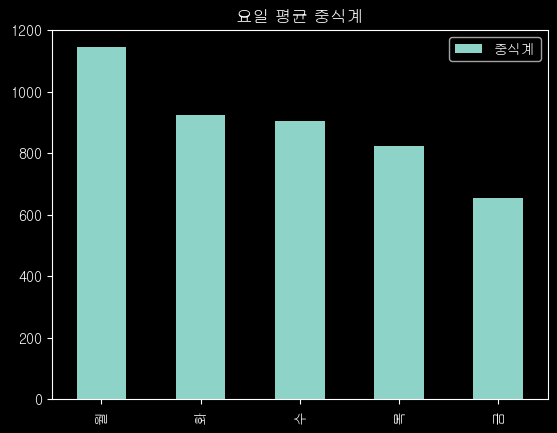

In [12]:
# df_day 활용해서 그래프 그리기
# 1. 월-금별 중식계 시각화 그래프
df_day.plot(kind = 'bar', y = '중식계')
plt.title('요일 평균 중식계')
plt.show()

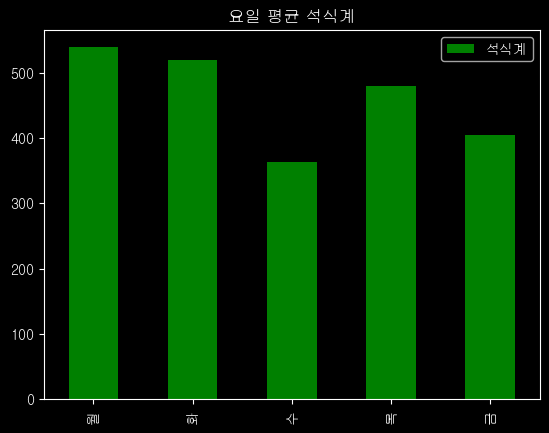

In [13]:
# 2. 월-금별 석식계 시각화 그래프
df_day.plot(kind = 'bar', y = '석식계', color = 'green')
plt.title('요일 평균 석식계')
plt.show()

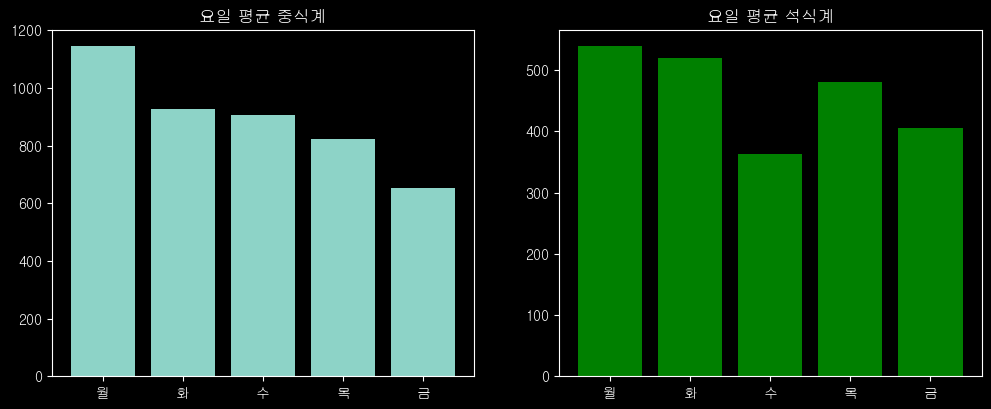

In [14]:
# 그래프를 한 개의 도화지 안에 나눠그리기.
plt.figure(figsize = (12, 4.5))

plt.subplot(1, 2, 1)
plt.bar(x = df_day.index, height = df_day['중식계'])
plt.title('요일 평균 중식계')

# 월요일이 중식계에 대한 식수가 가장 많음
# 주 초반에 직원들이 회사에 많이 출근하고 점심을 먹는 경향이 있음을 나타냄
# 주 후반으로 갈수록 식수는 감소하며, 금요일이 가장 낮은 중식계 시수를 보임

plt.subplot(1, 2, 2)
plt.bar(x = df_day.index, height = df_day['석식계'], color = 'green')
plt.title('요일 평균 석식계')

# 석식계 또한 월요일이 가장 많음을 확인
# → 월요일에 늦게까지 일하는 직원들이 많음을 의미

# 수요일에 식수가 감소함
# → 주중 중반의 수요일이라, 많은 직원들이 피로를 느낄 수 있음
# → 또는 정기적인 외부 미팅이나 회의가 잡혀있는 경우,
#    외부에서의 식사를 고려할 수 있음

# 목요일의 석식계 식수 증가
# 주 후반에 접어들며, 업무 마감을 준비하는 시기로 원인을 유추해볼 수 있음

# 금요일의 석식계 식수 감소
# 많은 직원들이 주말을 앞두고 조기 퇴근하거나,
# 사회적 약속이 많은 시기이므로 외부에서 식사하는 경우가 있는 듯 함

plt.show()

In [15]:
# 월별로 통계 확인
# datetime 자료형 활용
df['month'] = df['일자'].dt.month # 날짜별로 월만 추출
# 새로운 month 컬럼 추가

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
 12  month           1205 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(4), object(4)
memory usage: 117.8+ KB


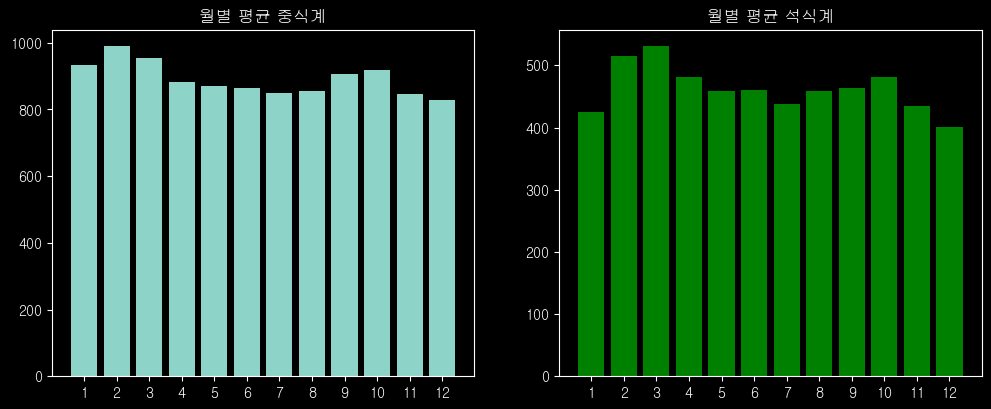

In [17]:
# 월별 중식계, 석식계 평균

# 1. df_month 변수에 월별 평균 중식계, 석식계 저장
df_month = df[['month', '중식계', '석식계']].groupby('month').mean()

# 2. 시각화(subplot 활용)
# 월별 평균 중식계, 석식계 그래프 그려보기
plt.figure(figsize = (12, 4.5))

plt.subplot(1, 2, 1)
plt.title('월별 평균 중식계')
plt.xticks(df_month.index) # 모든 x축 출력하기
plt.bar(x = df_month.index, height = df_month['중식계'])

plt.subplot(1, 2, 2)
plt.title('월별 평균 석식계')
plt.xticks(df_month.index) # 모든 x축 출력하기
plt.bar(x = df_month.index, height = df_month['석식계'], color = 'green')

plt.show()
# 2, 3월 식수가 높음 → 신입 사원 채용으로 먹는 사람의 인원 자체가 증가할 가능성이 있음
# 4~8월 휴가를 가는 사람들이 슬슬 생겨나서 인원이 감소

# 전체적으로 봤을 때는 차이가 거의 나보이지는 않음

In [18]:
df.head(3)
# 식수에 영향을 미치는 '메뉴'를 분석해보고 싶음
# 메뉴를 보고 구내식당에서 먹을지 외식을 할 건지 결정
# 메뉴 분석 전 전처리 과정이 필요함

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,month
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2


### 메뉴 전처리.

In [19]:
df['조식메뉴'][0]
# 메뉴가 공백(띄어쓰기)으로 구분되어있기는 하나 들쑥날쑥하게 구분이 되어있음
# ' ' → 로 바꿔서 확인.

'모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) '

In [20]:
df['조식메뉴'][0].replace(' ', '*')
# 공백으로 나눠져 있지만 균일하지 않게 한 개, 두 개로 엉망진창 구분이 돼있음

'모닝롤/찐빵**우유/두유/주스*계란후라이**호두죽/쌀밥*(쌀:국내산)*된장찌개**쥐어채무침**포기김치*(배추,고추가루:국내산)*'

In [21]:
# 띄어쓰기 3 → 2, 띄어쓰기 2 → 1
df['조식메뉴'] = df['조식메뉴'].str.replace("   ", "  ")
df['중식메뉴'] = df['중식메뉴'].str.replace("   ", "  ")
df['석식메뉴'] = df['석식메뉴'].str.replace("   ", "  ")

df['조식메뉴'] = df['조식메뉴'].str.replace("  ", " ")
df['중식메뉴'] = df['중식메뉴'].str.replace("  ", " ")
df['석식메뉴'] = df['석식메뉴'].str.replace("  ", " ")

# 띄어쓰기 1개를 기준으로 문자열 분리

In [22]:
df['조식메뉴'][0]

'모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산) '

In [23]:
df['조식메뉴'][0].replace(' ', '*')

'모닝롤/찐빵*우유/두유/주스*계란후라이*호두죽/쌀밥*(쌀:국내산)*된장찌개*쥐어채무침*포기김치*(배추,고추가루:국내산)*'

In [24]:
# 띄어쓰기를 기준으로 문자열 분리
df['조식메뉴'] = df['조식메뉴'].str.split(' ')
# 여러번 실행시키지 말기.

In [25]:
df['조식메뉴']

0       [모닝롤/찐빵, 우유/두유/주스, 계란후라이, 호두죽/쌀밥, (쌀:국내산), 된장찌...
1       [모닝롤/단호박샌드, 우유/두유/주스, 계란후라이, 팥죽/쌀밥, (쌀:국내산), 호...
2       [모닝롤/베이글, 우유/두유/주스, 계란후라이, 표고버섯죽/쌀밥, (쌀:국내산), ...
3       [모닝롤/토마토샌드, 우유/두유/주스, 계란후라이, 닭죽/쌀밥, (쌀,닭:국내산),...
4       [모닝롤/와플, 우유/두유/주스, 계란후라이, 쇠고기죽/쌀밥, (쌀:국내산), 재첩...
                              ...                        
1200    [모닝롤/페퍼로니피자, 우유/주스, 계란후라이/찐계란, 크루통크림스프/흑미밥, 아귀...
1201    [모닝롤/생크림단팥빵, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 떡국, 해...
1202    [모닝롤/BLT샌드위치, 우유/주스, 계란후라이/찐계란, 흑임자죽/흑미밥, 바지락살...
1203    [모닝롤/호박고구마오븐구이, 우유/주스, 계란후라이/찐계란, 누룽지탕/흑미밥, 감자...
1204    [모닝롤/야채샌드, 우유/주스, 계란후라이/찐계란, 참치죽/흑미밥, 홍합탕, 애호박...
Name: 조식메뉴, Length: 1205, dtype: object

In [26]:
df['중식메뉴'] = df['중식메뉴'].str.split(' ')
df['석식메뉴'] = df['석식메뉴'].str.split(' ')

In [27]:
print(df['중식메뉴'][0])
print(df['석식메뉴'][0])

['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '오징어찌개', '쇠불고기', '(쇠고기:호주산)', '계란찜', '청포묵무침', '요구르트', '포기김치', '(배추,고추가루:국내산)', '']
['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치', '(김치:국내산)', '']


In [28]:
# TF-IDF를 활용해 중요한 메뉴를 선정해보자.
# 공백을 기준으로 메뉴를 살펴보았을 때, 방문 혼잡도에 가장 영향을 미치는 요소는 메인 메뉴라고 판단됨
# 메뉴 선정에 불필요한 정보인 원산지 삭제
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF(Term Frequency - Inverse Document Frequency)
# 문서 내 단어의 빈도와 전체 문서에서의 희귀성을 반영한 가중치를 계산한 점수

In [29]:
# TF-IDF를 위해 리스트를 문자열로 변환하여 저장
df['조식메뉴'] = df['조식메뉴'].apply(lambda x : ' '.join(x))
df['중식메뉴'] = df['중식메뉴'].apply(lambda x : ' '.join(x))
df['석식메뉴'] = df['석식메뉴'].apply(lambda x : ' '.join(x))
# lambda(익명 함수) : 주로 간단한 함수(재사용이 필요없는)가 필요할 때 사용

In [30]:
df['조식메뉴'].head(1)

0    모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무...
Name: 조식메뉴, dtype: object

In [31]:
# 불필요한 정보(원산지 정보) 제거 함수 정의
def remove_pattern(text):
    return re.sub(r'\([^)]*\)', '', text)
# \( : 여는 괄호 (의미
# [^)]* : )를 제외한 모든 문자를 *(0번 이상 반복) 의미
# \) : 닫는 괄호 )의미

In [32]:
remove_pattern(df['조식메뉴'][0])

'모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥  된장찌개 쥐어채무침 포기김치  '

### TF-IDF 활용하여 단어의 중요도 계산해주고, 상위 1ea 메뉴만 선정

In [33]:
vectorizer = TfidfVectorizer() # TF-IDF 객체 초기화

In [34]:
# 조식, 중식, 석식 메뉴별 TF-IDF 점수 변환
X = vectorizer.fit_transform(df['중식메뉴'])

In [35]:
vectorizer.get_feature_names_out()

array(['d오리엔탈d', 'la갈비구이', 'new', ..., '흑임자드레싱', '흑임자연근샐러드', '히레카츠'],
      dtype=object)

In [36]:
# TF-IDF 점수를 DF 변환
tfidf_df = pd.DataFrame(
    X.toarray(),
    columns = vectorizer.get_feature_names_out()
)
tfidf_df.head()

,d오리엔탈d,la갈비구이,new,가래떡구이,가래떡돼지갈비찜,가래떡츄러스,가자미무조림,가자미양념찜,가자미엿장구이,가자미엿장조림,...,훈제오리냉채,훈제오리단호박볶음,훈제오리마늘볶음,훈제오리볶음,흑미,흑미밥,흑임자d,흑임자드레싱,흑임자연근샐러드,히레카츠
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# 각 메뉴별로 TF_IDF 점수가 가장 높은 1개의 단어의 인덱스를 추출
top_n_idx = tfidf_df.iloc[0].argmax()

In [38]:
# 메뉴(단어사전)
tfidf_df.columns[top_n_idx]
# 추출한 메뉴 인덱스로 메뉴 인덱싱

'오징어찌개'

In [39]:
# 모든 데이터에서 메뉴중에 점수가 가장 높은 1개의 인덱스를 추출하여 메인메뉴 뽑는 함수 만들기
def extract_main(menu_series):
    vectorizer = TfidfVectorizer() # TF-IDF 객체 생성
    X = vectorizer.fit_transform(menu_series) # TF-IDF 점수 생성

    tfidf_df = pd.DataFrame(X.toarray(),
                           columns = vectorizer.get_feature_names_out())

    # 각 행별로 TF-IDF 점수가 가장 높은 단어를 추출
    def top_tfidf_word(row):
        top_n_idx = row.argmax() # 각 메뉴별로 TF-IDF 점수가 가장 높은 인덱스 추출
        return tfidf_df.columns[top_n_idx]

    return tfidf_df.apply(top_tfidf_word, axis = 1)

In [40]:
df['조식메뉴_Main'] = extract_main(df['조식메뉴'])
df['중식메뉴_Main'] = extract_main(df['중식메뉴'])
df['석식메뉴_Main'] = extract_main(df['석식메뉴'])

In [41]:
# Main 메뉴 확인
df[['조식메뉴_Main', '중식메뉴_Main', '석식메뉴_Main']]

,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,쥐어채무침,오징어찌개,건파래무침
1,단호박샌드,김치찌개,콩나물밥
2,느타리호박볶음,견과류조림,황태
3,근대국,부추전,미니김밥
4,방풍나물,돈육씨앗강정,감자소세지볶음
...,...,...,...
1200,마늘종숙회,견과류마카로니범벅,맛살튀김
1201,생크림단팥빵,버섯숙회,비엔나채소볶음
1202,바지락살국,계란파국,수제맛쵸킹탕수육
1203,분홍소세지구이,양념김,생강채


In [42]:
# main menu 가지 수 파악
display(df['조식메뉴_Main'].value_counts().head(10))
print()
display(df['중식메뉴_Main'].value_counts().head(10))
print()
display(df['석식메뉴_Main'].value_counts().head(10))

조식메뉴_Main
도라지나물      9
연두부탕       8
느타리볶음      8
김잔파무침      8
조랭이떡국      7
문어꽈리초조림    7
두부쑥갓무침     7
대구탕        7
쑥갓두부무침     7
브로컬리들깨찜    7
Name: count, dtype: int64

중식메뉴_Main
견과류조림       5
유자청돈육볶음     5
new         5
참나물땅콩무침     4
두부새싹구이      4
사과고구마그라탕    4
해파리겨자채      4
해파리냉채       3
청경채사과생채     3
물파래무침       3
Name: count, dtype: int64

석식메뉴_Main
1컷팅해서     28
자기계발의날     7
자기개발의날     6
애호박나물      5
닭살겨자냉채     5
군고구마       4
군만두        4
세발나물       4
상추파무침      4
모듬튀김       4
Name: count, dtype: int64

### Menu Data EDA(탐색적 데이터 분석)

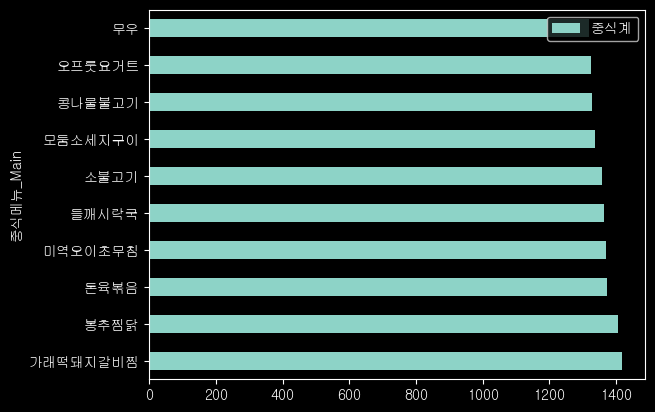

In [43]:
# main menu 별 중식계 식수 인원 확인
df_lunch = pd.DataFrame(df.groupby('중식메뉴_Main')['중식계'].mean())
df_lunch10 = df_lunch.sort_values(by=['중식계'], ascending = False).head(10)
df_lunch10.plot(kind = 'barh')
plt.show()

# ascenging = False(내림차순)
# 가래떡돼지갈비찜부터 맜있어 보이는 메뉴가 중식계 식수가 높다

# ascending = True(오름차순) : 가장 인기가 없는 메뉴
# 크리스마스 케익이 가장 인기가 없음을 확인

# 인기가 많은 Main Menu일 때는, 사용자 만족을 위해서 재고를 좀더 준비해보면 좋을 것 같다.
# 인기가 없는 Main Menu일 때는, 기존 메뉴에 대한 보완책을 고려해볼 필요성이 있겠다.

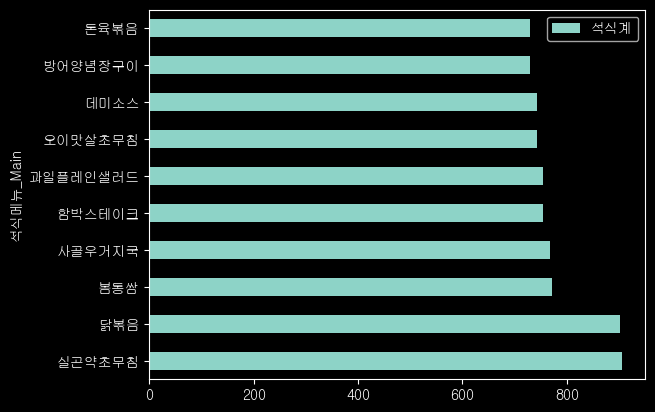

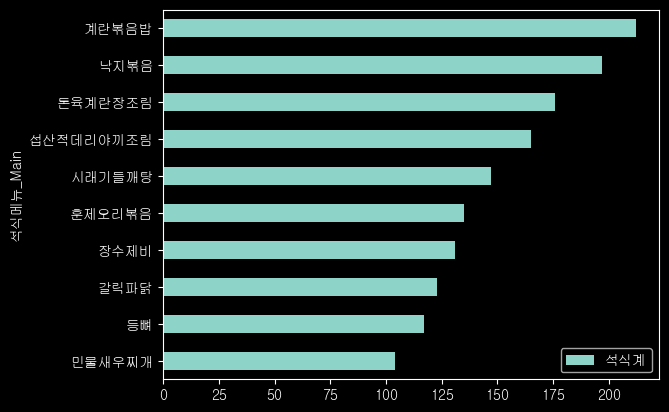

In [44]:
df_lunch = pd.DataFrame(df.groupby('석식메뉴_Main')['석식계'].mean())
df_lunch10 = df_lunch.sort_values(by=['석식계'], ascending = False).head(10)
df_lunch10.plot(kind = 'barh')
plt.show()

# 오름차순(ascending=True)
# 가정의날, 자기개발의날, 자기계발의날 등 메뉴가 아닌것들이 확인
# 석식 메뉴가 없는 데이터도 존재한다는 것을 확인함
# 메뉴가 없는날의 데이터는 삭제해도 되지않을까?

df_lunch10 = df_lunch.sort_values(by=['석식계'], ascending = True).head(17)[7:]
df_lunch10.plot(kind = 'barh')
plt.show()

# 내림차순(ascending=False)
# 실곤약초무침, 닭볶음이 높게 관측되었지만 중식계에 비해서는 식수인원이 부족함이 확인됨
# 기본적으로 석식을 먹는 인원이 중식에 비해서 훨씬 적음을 알 수 있다.
# 석식을 먹는 인원이 적기 때문에 그만큼 재고관리의 중요도가 높음

In [45]:
# 석식계 == 0에 대한 개수 확인
sum(df['석식계'] == 0)

# 특정 이벤트나 활동이 있을 때 석식이 제공되지 않는다.
# 전체 데이터 1205ea 중 43ea로 확인되기 때문에 개수가 적어서 제거하는 쪽으로 진행

43

In [46]:
# 석식계 0인 행을 삭제
df = df[df['석식계'] != 0] # 석식계가 0이 아닌 데이터로 df 갱신

In [47]:
df.shape # 1205ea -> 1162ea로 줄어든 것을 확인.

(1162, 16)

### 모델링을 위한 준비
- 데이터 스케일링 수행
  - 비지도 학습 중 클러스터링(군집화) 기법으로 클러스터링 분석을 수행하고자 함
  - 사용하고자 하는 군집 알고리즘(K-means, 병합군집)은 거리 기반 알고리즘이기 때문에 모든 Feature가 동일한 스케일을 가지도록 스케일링이 필요함

- 범주형 데이터 인코딩
  - sklearn에서 제공하는 모델은 입력값으로 문자열을 지원하지 않음
  - 요일, main메뉴 등의 범주형 feature에 대해서 인코딩을 진행해야 한다.

In [48]:
df.drop(['일자', '조식메뉴', '중식메뉴', '석식메뉴'], inplace = True, axis = 1)
# 불필요한 컬럼 삭제
# 일자 : 클러스터링에 직접적으로 사용하지 않음, 이미 month 컬럼을 추출
# 조식, 중식, 석식 : Main메뉴 추출했기 때문에 사용하지 않음

In [49]:
df.head(1)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,월,2601,50,150,238,0.0,1039.0,331.0,2,쥐어채무침,오징어찌개,건파래무침


In [50]:
# numeric(수치형), categorical(범주형) 컬럼 나누기

numeric_list = [] # 수치형 컬럼명 담을 list
categorical_list = [] # 범주형 컬럼명 담을 list

for i in df.columns:
    if df[i].dtypes == 'O':
        categorical_list.append(i)
    else:
        numeric_list.append(i)

# if df[i].dtypes == 'O' -> 컬럼의 데이터 타입이 'O'(Object, 문자열)인지 여부 확인
# 'int64', : 64비트 정수형 / 'float32' : 32비트 실수형 / 'bool' : 불리언형

In [51]:
print("수치형", numeric_list)
print("범주형", categorical_list)

수치형 ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계', 'month']
범주형 ['요일', '조식메뉴_Main', '중식메뉴_Main', '석식메뉴_Main']


### 스케일링 선택 및 적용을 위한 데이터 분포 확인
1. StandardScaler : 데이터를 평균이 0, 표준편차가 1이 되도록 변환
   - 데이터가 정규분포(또는 근사 정규분포)를 따르는 경우 적용
   - 이상치가 있어도, 평균과 표준편차가 극단적이지 않은 경우
2. MinMaxScaler : 데이터를 최소값 0, 최대값 1로 변환
   - 데이터가 정규분포를 따르지 않는 경우
   - 이상치(Outlier)가 있을 때 영향을 최소화 하고 싶은 경우
   - 특정 범위로 데이터를 변환해야 할 때(이미지 처리)

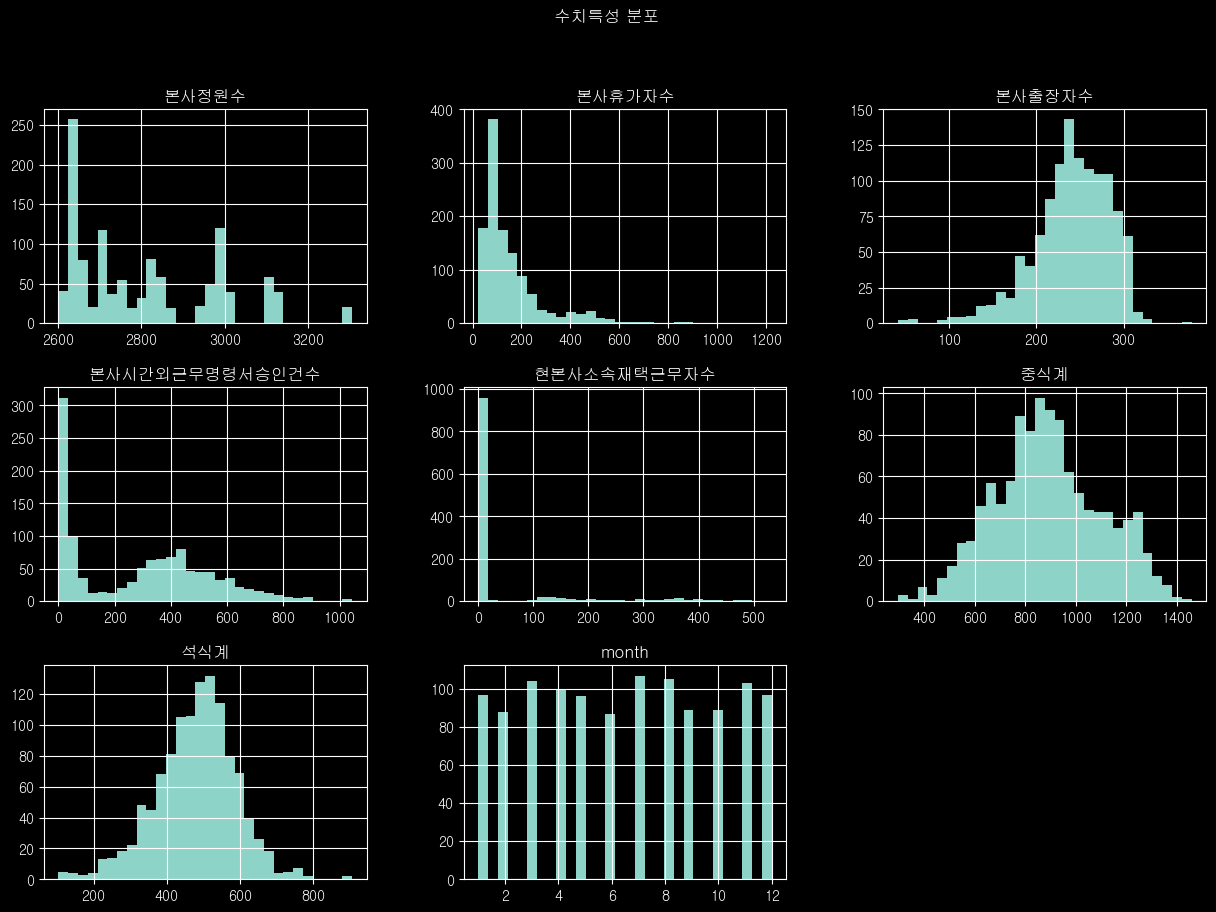

In [52]:
plt.style.use(['dark_background']) # 차트 배경을 어둡게
# 데이터 분포 확인을 위해 히스토그램 그려보기
df[numeric_list].hist(
    bins = 30, # 히스토그램 막대의 개수
    figsize = (15, 10)
)
plt.suptitle('수치특성 분포')
plt.show()

### 히스토그램 해석

| 항목 | 분포 형태 | 설명 |
| --- | --- | --- |
| **본사정원수** | 다중 피크를 가진 비정규 분포 | 특정 구간에서 집중되는 경향이 있으며, 전체 범위가 비교적 넓음 |
| **본사휴가자수** | 왼쪽으로 치우친 비대칭 분포 | 대부분의 값이 0에서 200 사이에 집중되어 있으며, 일부 높은 값들이 존재함 |
| **본사출장자수** | 정규분포에 가까움 | 값이 평균을 중심으로 어느 정도 고르게 분포되어 있음 |
| **본사시간외근무명령서승인건수** | 왼쪽으로 치우친 비대칭 분포 | 대부분의 값이 0에서 400 사이에 집중되어 있으며, 일부 높은 값들이 존재 |
| **현본사소속재택근무자수** | 매우 왼쪽으로 치우친 비대칭 분포 | 대부분의 값이 0에 매우 가깝게 집중되어 있으며, 일부 높은 값들이 존재함 |
| **중식계** | 정규분포에 가까움 | 값이 평균을 중심으로 고르게 분포되어 있음 |
| **석식계** | 정규분포에 가까움 | 값이 평균을 중심으로 고르게 분포되어 있음 |
| **month** | 균등 분포 | 각 월이 조금씩 차이가 있으나, 균등하게 분포되어 있음 |

### 스케일링 방법 선택
- 모든 피처가 동일한 스케일링을 가지도록, 하나의 스케일링 방법으로 일관되게 처리하는 것이 중요
- 앞서 본 데이터 분포를 고려할 때, 대부분의 피처가 정규분포를 따르지 않는 경향이 있으므로, MinMaxScaler 활용

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = df.copy() # 강한 복사 -> 주소값이 다름 -> 복사본을 변경해도 원본에 지장이 없다.
# df_scaled = df : 얕은 복사 -> 주소값을 공유 -> 복사본 데이터를 변경하면 원본도 바뀜

# 스케일링 적용
df_scaled[numeric_list] = scaler.fit_transform(df_scaled[numeric_list])

In [54]:
df_scaled.head(1)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
0,월,0.0,0.022481,0.323442,0.227969,0.0,0.638865,0.283396,0.090909,쥐어채무침,오징어찌개,건파래무침


### 수치데이터 상관관계 분석
- 히트맵 : 각 컬럼끼리 선형관계가 얼마나 짙은지를 나타내는 차트
- -1 ~ 1 : 0에 가까울수록 비선형관계, -1에 가까울수록 반비례적인 관계를 나타냄, 1에 가까울수록 비례 관계를 나타낸다

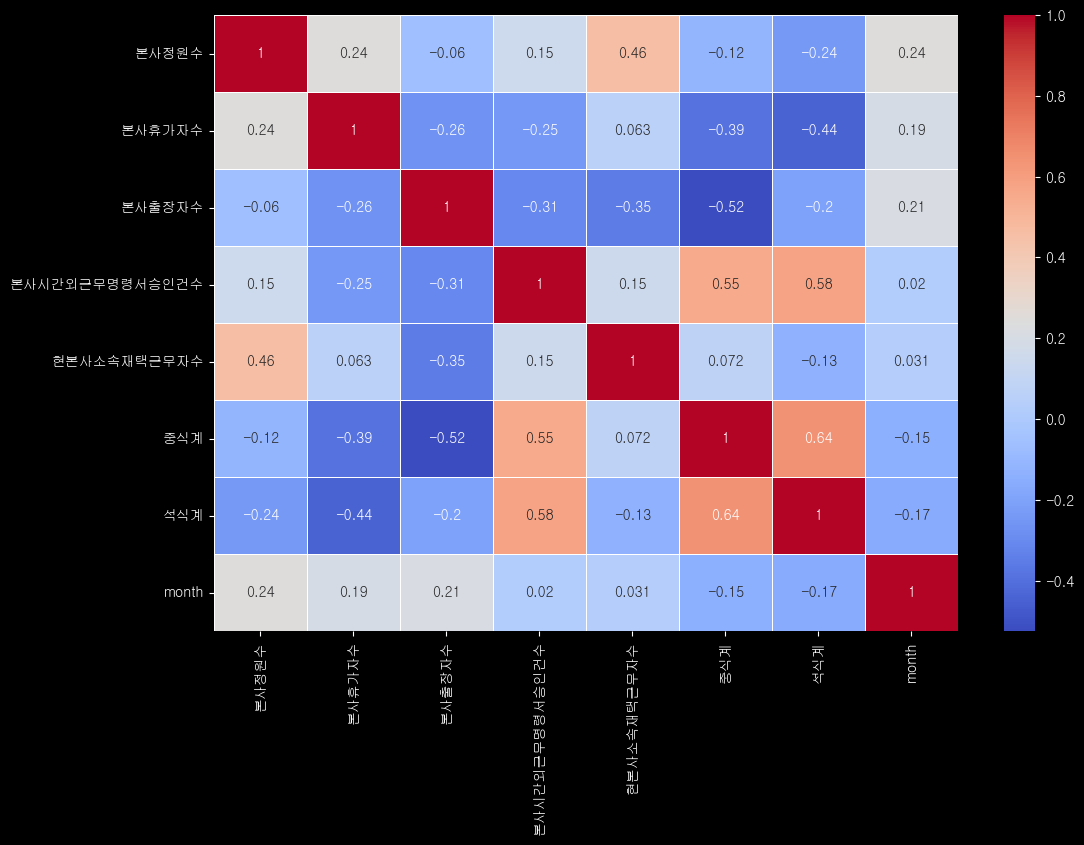

In [55]:
import seaborn as sns
plt.rcParams["axes.unicode_minus"] = False # '_' 기호를 차트에 표현

corr_matrix = df_scaled.corr(numeric_only = True) # 상관계수 계산

# 히트맵 그리기
plt.figure(figsize = (12, 8))
sns.heatmap(
    corr_matrix, # 히트맵에 그릴 상관계수(행렬)
    annot = True, # 각 셀에 상관계수 값을 표시 여부
    cmap = "coolwarm", # 색상값
    linewidths = 0.5 # 셀끼리의 경계선 두께
)
plt.show()

#### 상관관계가 높은 특성은 클러스터일레 더 큰 영향을 미칠 수 있으므로 주의깊게 다루어야 함
### 클러스터링 전 추가작업
- 상관관계 낮은 피처 제거 : 상관관계 매우 낮거나 클러스터링에 큰 영향을 미치지 않는 특성을 제거할 수 있음
- 특성 변환 : 상관관계가 높은 특성을 조합하여 새로운 특성을 생성할 수 있음
- 현재 상태에서 추가적인 특성 제거는 필요하지 않음으로, 모든 피처를 활용하여 클러스터링 진행

In [56]:
# 인코딩 적용
# label : 값이 높고 낮음이 의미가 있을 때
# one-hot : 값이 높고 낮음이 의미가 없을 때

### One-hot encoding
- 각 범주를 고유한 열로 나타내고, 해당하는 범주에는 1을, 그렇지 않은 범주에는 0을 넣음
  - 범주형 데이터를 이진 벡터로 변환
- 장점 : 모든 범주형 변수를 균등하게 처리할 수 있음
- 단점 : 고유값이 많은 경우 차원이 크게 증가할 수 있음

In [57]:
df_scaled['요일'].unique()
# 월, 화, 수, 목, 금 -> 5ea기 때문에 원핫인코딩을 수행해도 차원이 크게 증가하지 않음

array(['월', '화', '수', '목', '금'], dtype=object)

In [58]:
len(df_scaled['조식메뉴_Main'].unique())
# 조식메뉴_Main의 경우에는 원핫인코딩을 수행할 경우에 차원이 589나 늘어나버린다 -> 다른 인코딩은 없을까?

589

In [59]:
# 요일에 대해서 원핫인코딩 수행
df_scaled = pd.get_dummies(df_scaled, columns = ['요일'])

### 빈도 인코딩(Frequency Encoding)
- 각 범주를 해당 범주의 빈도로 대체
- 장점 : 범주형 변수의 발생 빈도를 반영함
- 단점 : 빈도가 같을 때 구분이 어려움
- 군집화 분석은 데이터 내의 유사한 특성을 가진 그룹을  지도 학습 방법
- 빈도 인코딩은 군집화 분석에서 메뉴의 빈도가 식수인원에 어떤 영향을 미치는지 분석하는데 도움이 될 것.

In [60]:
# 빈도 인코딩 적용
for column in categorical_list[1:]:
    map_dict = df_scaled[column].value_counts().to_dict()
    # map()으로 매핑해주기 위한 인자값 딕셔너리 생성
    df_scaled[f'{column}_encoded'] = df_scaled[column].map(map_dict)
    # 각 빈도수별로 요소를 바꿔주고 encoded 컬럼을 추가

In [61]:
df_scaled[['조식메뉴_Main', '조식메뉴_Main_encoded']]

,조식메뉴_Main,조식메뉴_Main_encoded
0,쥐어채무침,1
1,단호박샌드,4
2,느타리호박볶음,5
3,근대국,2
4,방풍나물,4
...,...,...
1200,마늘종숙회,1
1201,생크림단팥빵,1
1202,바지락살국,1
1203,분홍소세지구이,1


In [62]:
df_encoded = df_scaled.drop(columns = categorical_list[1:])
# Main컬럼 삭제

### K-Means 알고리즘
- 비슷한 샘플끼리 군집 형성하기
- 쉽고 간결함
- 거리기반 알고리즘으로 속성의 개수가 많은 경우 군집화의 정확도가 떨어짐
- 몇 개의 군집(k수)을 선택할지 정확히 알 수 없음

In [63]:
!pip install mglearn
# 머신러닝 교육 및 시각화를 위한 도구를 제공하는 라이브러리

Defaulting to user installation because normal site-packages is not writeable


D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

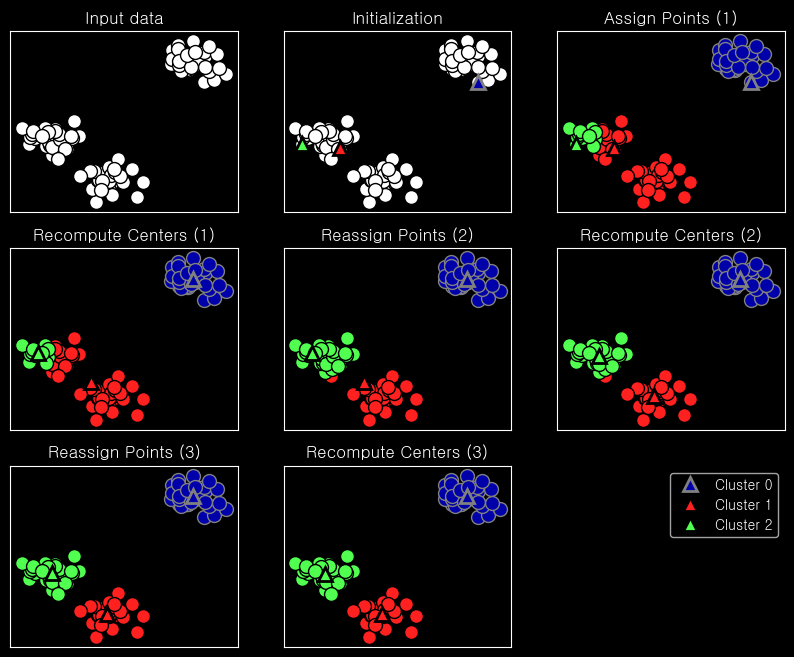

In [64]:
from sklearn.cluster import KMeans
import mglearn
mglearn.plots.plot_kmeans_algorithm() # Kmeans 알고리즘의 작동방식을 시각화
# 1. 임의로 Centroid 선정
# 2. Centroid로부터 가까운 데이터 포인트 선점
# 3. 선점한 데이터 포인트의 평균 중심점 Centroid 이동
# 4. centroid의 이동이 더이상 없을 때까지 반복이 진행된다.

In [65]:
# 모델 초기화
model = KMeans(
    n_clusters = 3, # 클러스터의 수 설정
    n_init = 10, # 초기 centroid를 무작위로 선택하는 횟수를 설정, 가장 괜찮은 결과를 선택
    random_state = 2025 # 시드 고정, 결과 재현성
)

In [66]:
# 모델 학습
model.fit(df_encoded)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=2025)

In [67]:
model.predict(df_encoded)

array([1, 0, 2, ..., 1, 1, 1], dtype=int32)

In [68]:
pd.Series(model.predict(df_encoded)).value_counts()

1    515
0    353
2    294
Name: count, dtype: int64

### 최적의 클러스터 수를 결정하기 위한 3가지 방법
1. 관성과 군집수(엘보우 기법)
2. 실루엣 점수와 군집수
3. 실루엣 다이어그램과 군집수

### 방법 1 : 관성과 군집수(엘보우 기법)
- 기울기가 가장 완만해지는 k 수 찾기 -> 가장 효율적인 클러스터 수라고 고려해볼 수 있다.
- 직관적이고 간단하나, 엘보우 지점 선택 과정에서 주관이 개입될 수 있다.
- 엘보우 지점이 명확하지 않을 수 있음

In [69]:
# Inertia : 군집화 된 후에, 각 중심점에서 군집의 데이터간의 거리를 합산한 값
# 군집의 응집도를 나타낸 값
model.inertia_ # SSE(Sum of Squared Error, 관성) 값

# 실제 Error보다는 군집 내의 데이터 포인트가 중심에 얼마나 가까운지 알기 위한 값

3274.9960275137887

In [70]:
# Elbow Methos(엘보우 방식) 시각화
# 클러스터 범위 설정
ks = range(1, 31)

In [71]:
# 각 클러스터 개수에 대해서 KMeans 모델을 훈련하고 SSE 계산
k_means = [KMeans(n_init = 10, n_clusters = k, random_state = 2025).fit(df_encoded) for k in ks]
inertias = [model.inertia_ for model in k_means]

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

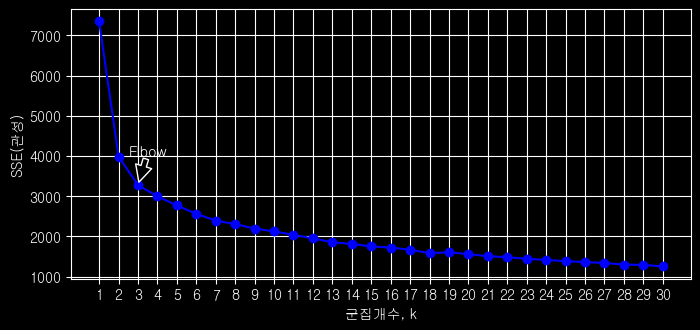

In [72]:
# 군집 개수에 따른 관성(SSE) 값을 시각화
plt.figure(figsize=(8, 3.5))

# x축: 클러스터 개수, y축: SSE(관성), "bo-"는 파란색 점과 선
plt.plot(ks, inertias, "bo-")

plt.xlabel('군집개수, k')
plt.ylabel('SSE(관성)')

### 생략 가능 ###
# Elbow 포인트에 화살표 추가
plt.annotate(
    "",  # 주석 텍스트 없음
    xy=(3, inertias[2]), # 화살표 머리 위치 (클러스터 수 3, 해당 클러스터의 관성 값)
    xytext=(3.45, 4000), # 화살표 꼬리 위치 (x=3.45, y=4000)
    arrowprops=dict(facecolor='black', shrink=0.1)  # 화살표 속성 설정 (검은색, 끝 부분을 10% 축소)
)

# Elbow 포인트에 텍스트 추가
plt.text(
    3.5, 4000,  # 텍스트 위치 (x=3.5, y=4000)
    "Elbow",  # 추가할 텍스트
    horizontalalignment="center" # 텍스트를 수평으로 중앙 정렬
)
######

plt.xticks(ks) # x축 틱 설정
plt.grid() # 그리드 추가
plt.show()

In [73]:
# 왜 기울기가 완만한 지점에서 최적의 클러스터라고 판단하는가?
# 더 많은 클러스터를 추가해도 클러스터 내의 데이터 포인트가 중심에 극적으로 가까워지지는 않기 때문에.

### 엘보우 포인트 결정
- 엘보우 포인트 : 차트에서 ineria의 감소율이 급격히 줄어드는 지점
- 차트 관찰 : 클러스터 수가 3일 때 엘보우 포인트가 나타남
- 최적의 클러스터 수 : 3으로 판단

### 실루엣 점수(Silhouette score)
- 얼마나 효율적으로 잘 분리되었는지를 나타냄(분리도, 응집도)
- 1에 가까울 수록 잘 나눴다.
- 0에 가까울 수록 애매함.
- -1에 가까울 수록 잘못 군집화 되어있거나, 데이터 셋이 클러스터링을 할 수 없는(거리기반에 한해서) 데이터 셋

In [74]:
from sklearn.metrics import silhouette_score
# 전체 데이터에 대한 평균 실루엣 점수를 계산해주는 도구
# silhouette_score(feature, pred)
k_means[2] # k = 3 kmeans모델
k_means[2].labels_ # 학습한 데이터셋에 대한 예측값

array([1, 0, 2, ..., 1, 1, 1], dtype=int32)

In [75]:
silhouette_score(df_encoded, k_means[2].labels_)

np.float64(0.2581332633279275)

In [76]:
# 각 클러스터 개수에 대한 실루엣 점수 계산(k = 2)
sil_scores = [silhouette_score(df_encoded, model.labels_) for model in k_means[1:]]

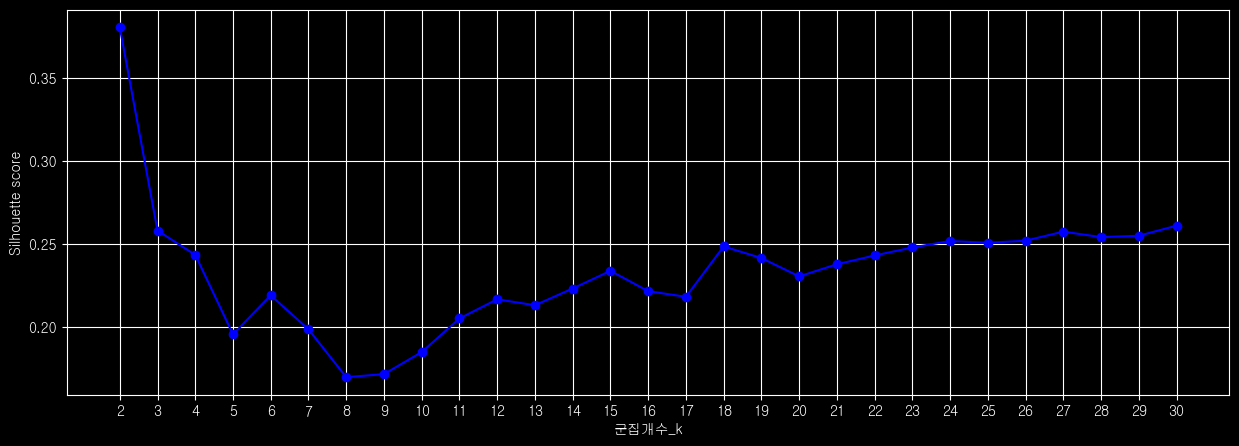

In [77]:
plt.figure(figsize = (15, 5))
plt.plot(ks[1:], sil_scores, "bo-") # bo- : 파란색 점과 선
plt.xlabel("군집개수_k")
plt.xticks(ks[1:])
plt.ylabel("Silhouette score") # 평균 실루엣 계수
plt.grid()
plt.show()

- k = 2에서 실루엣 점수가 약 0.35로 가장 높다
- k = 3에서 실루엣 점수가 약간 감소하지만 여전히 높은편
- k = 27 이후로도 비슷한 값이 등장하지만 거리기반 알고리즘의 계산 효율성을 위해서 더 적은 클러스터를 선택하는 것이 좋다
> 실루엣 점수를 기반으로 한 최적의 클러스터 수는 2 또는 3이 될 가능성이 커보임

### 방법 3 : 실루엣 다이어그램과 군집수
- 군집별로 각 샘플의 실루엣 개수를 오름차순으로 정렬한 그래프인 실루엣 다이어그램이 보다 많은 정보를 전달
- 실루엣 다이어그램 분석
  - 평균 실루엣 지수 분석에서 더 나아가 분석을 할 수 있다.

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

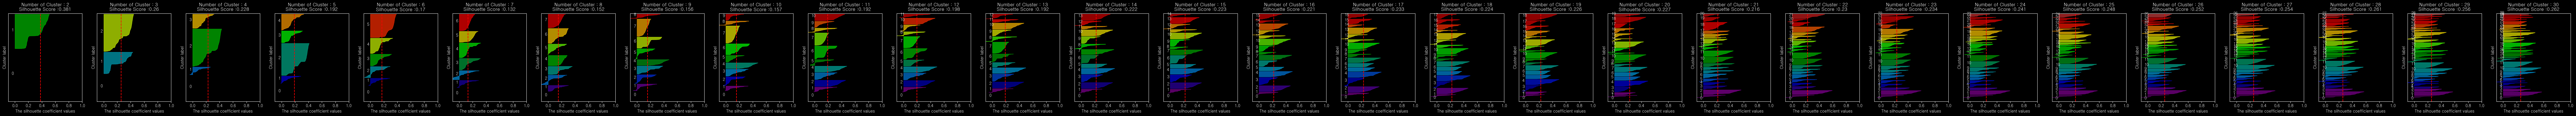

In [78]:
# 실루엣 다이어그램 호출하기
from shrd.plot.silhouette_plot import visualize_silhouette
visualize_silhouette(ks[1:], df_encoded) # (클러스터범위, 군집분석대상)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

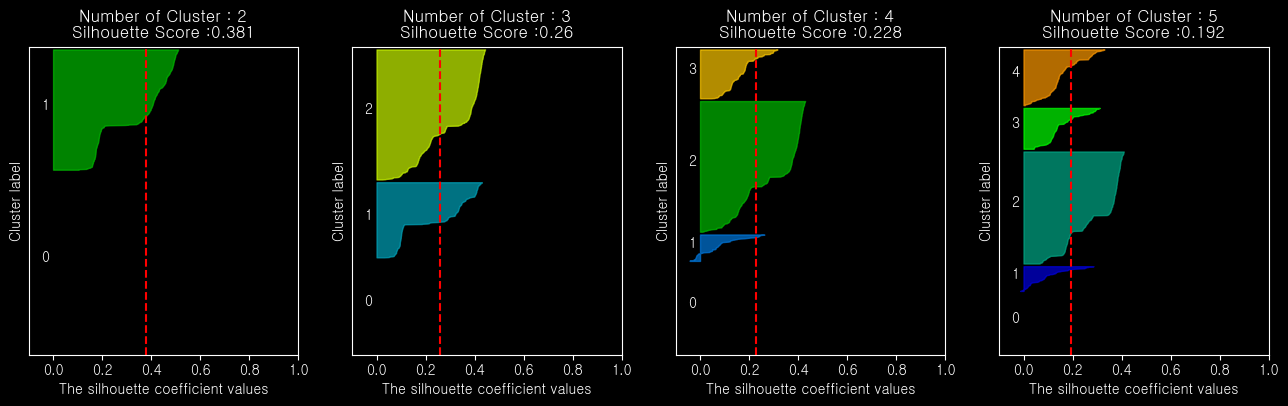

In [79]:
visualize_silhouette(ks[1:5], df_encoded) # (클러스터범위, 군집분석대상)

### 그래프 해석 방법
- 각 그래프는 서로 다른 클러스터 개수(k)를 나타내며, 실루엣 계수의 분포를 보여줌
- 실루엣 칼날 : 각 클러스터에 속하는 데이터의 포인트의 실루엣 계수 분포를 나타냄
  - 각 칼날은 하나의 클러스터를 의미하며, 실루엣 계수가 큰 값에서 작은 값으로 정렬되어 있음
  - 칼날의 너비가 넓을수록 클러스터의 응집도가 높고, 다른 클러스터와 잘 분리된다는 것을 의미
- 빨간색 점선 : 전체 데이터 포인츠의 평균 실루엣 계수를 나타냄
  - 점선의 값이 클수록 클러스터링의 품질이 높음

- 추가 : Dendrogram을 통한 k 수 찾아보기.

In [80]:
from scipy.cluster.hierarchy import dendrogram, linkage
# dendrogram : 계층적 군집 결과 (linked)를 트리 형태로 시각화
# linkage : 계층적 군집(Hierarchical Clustering, 하이라키칼 클러스터링)

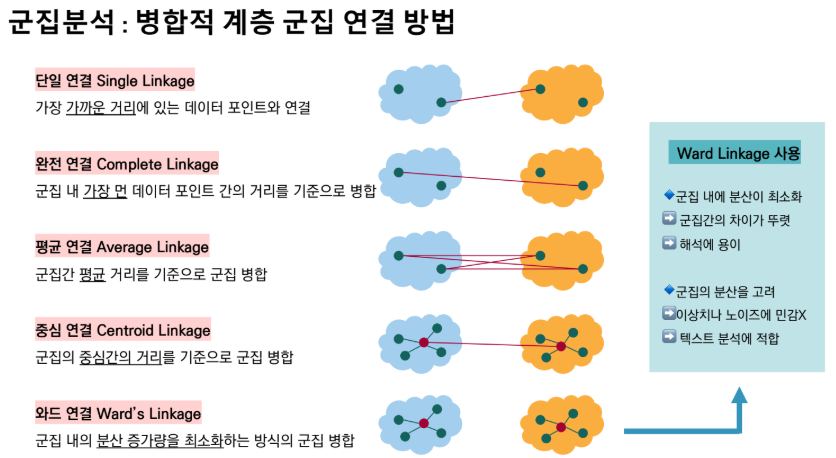

In [81]:
# 계층적 군집 수행
linked = linkage(
    df_encoded.values, # 군집화할 데이터(군집 알고리즘에서 요구하는 입력형태에 맞게끔 2차원 배열로 넣어줌.)
    "ward" # 군집 방식 지정 ('ward' -> 군집 내의 분산 증가량을 최소화하는 방식)
)

In [82]:
linked.shape
# 총 데이터에 1162개 문서가 있다면, 계층적 군집에서 문서가 하나로 합쳐질때까지 총 1161(n-1)번의 병합이 발생한다
# (1161, 4)
# 1161번의 병합단계, 4ea의 컬럼
# [클러스터1 인덱스, 클러스터2 인덱스, 군집 간의 거리, 병합된 새 클러스터가 포함하는 데이터 포인트 수]

(1161, 4)

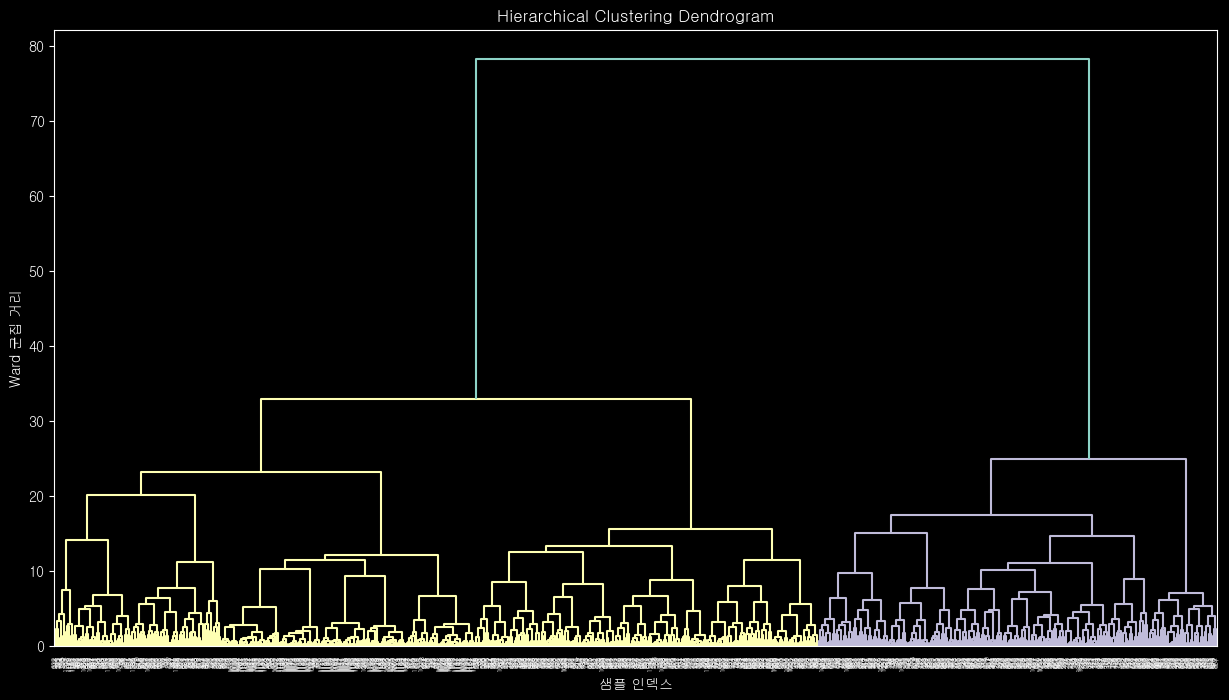

In [83]:
# 덴드로그램 시각화
plt.figure(figsize = (15, 8))

dendrogram(
    linked,                       # 계층적 군집 결과
    labels = df_encoded.index.astype(str),   # 각 샘플의 인덱스를 라벨로
    orientation = 'top',          # 덴드로그램의 방향 (위에서 아래로 그리기 (left, right, bottom))
    distance_sort = 'descending', # 클러스터 간 거리를 기준으로 내림차순 정렬
    show_leaf_counts = True,      # 리프 노드(최종 말단)마다 샘플 개수 표시 여부
    color_threshold = 35,          # y축 기준 -> 35 이상은 동일 색상(군집)으로 묶이지 않도록 설정
)
plt.xlabel("샘플 인덱스")
plt.ylabel("Ward 군집 거리")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

### 적잘힌 k 수는 3으로 판단됨
- k = 2도 고려해볼 수 있음 -> 최적의 k수를 찾는 지표값이 절대적인 값은 아님.
- 클러스터링 이후, 각 클러스터링의 특성을 이해하고 클러스터별로 재고 관리 전략을 수립하는 것이 중요.

- 덴드로그램을 그렸을 때 y축 값이 낮은 지점에서 클러스터링된 문서는 서로 비슷한 내용일 가능성이 높음
- y축 값이 높은 곳에서 함쳐지는 문서는 거리가 멀었다가 뒤늦게 합쳐진 것이기 때문에 다른 내용일 가능성이 높다.

In [84]:
# 최적의 k수로 모델 초기화
model = KMeans(n_clusters = 3, n_init = 10, random_state = 2025)
# 학습하며 예측 수행
kmean_pred = model.fit_predict(df_encoded)
# 예측한 클러스터링 결과를 컬럼으로 추가
df_encoded['cluster'] = kmean_pred

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [85]:
# cluster별로 메뉴를 확인하기 위해서, 원본 데이터에서 불리언 인덱싱 수행
df[df_encoded['cluster'] == 0]['조식메뉴_Main'].value_counts()

조식메뉴_Main
단호박샌드    4
방풍나물     4
봄동된장국    4
콩조림      4
밤죽       4
        ..
쥐포무침     3
북어채      3
만두국      3
애플파이     3
가지볶음     1
Name: count, Length: 104, dtype: int64

In [86]:
df_cluster_0 = df[df_encoded['cluster'] == 0].copy() # 얕은 복사를 방지
df_cluster_1 = df[df_encoded['cluster'] == 1].copy()
df_cluster_2 = df[df_encoded['cluster'] == 2].copy()

In [87]:
df_cluster_0.groupby('요일')[['중식계', '석식계']].mean()

,중식계,석식계
요일,,
금,683.773333,431.960000
목,847.859155,502.605634
수,932.764706,453.568627
월,1164.060241,558.819277
화,905.164384,526.671233


In [88]:
df_cluster_1.groupby('요일')[['중식계', '석식계']].mean()

,중식계,석식계
요일,,
금,629.257143,374.247619
목,819.063063,462.963964
수,905.820000,421.230000
월,1151.312500,532.697917
화,931.728155,515.708738


In [89]:
df_cluster_2.groupby('요일')[['중식계', '석식계']].mean()

,중식계,석식계
요일,,
금,656.644068,439.101695
목,805.483871,486.193548
수,895.895833,451.020833
월,1107.112903,521.967742
화,948.492063,528.031746


In [90]:
# 요일별 중식계, 석식계 확인 해본 결과, 맨 처음에 클러스터링을 진행하지 않은 지표와 크게 차이가 없다
# -> 클러스터링을 한 의미가 크게 없다 -> 거리기반이 아닌 다른 클러스터링을 수행해볼 수 있을까?

### KMeans(기타 거리기반 클러스터링) 장단점
- 장점
  - 구현과 이해가 쉬움
  - 해석하기도 쉬움
  - 군집이 잘 형성되어 있는 데이터셋이라고 한다면, 효율적임
- 단점
  - 적절한 k 수를 찾아야함 -> 여러가지 분석적 접근이 필요함
  - Centroid를 중심으로 클러스터링을 수행하기 때문에 구형 클러스터는 잘 찾으나, 복잡한 모양의 클러스터(ex. 원형, 도넛, 고리 모양 등)는 처리하기 어려움
  - 이상치에 매우 민감하며, 잘못된 클러스터링이 수행될 수도 있다.
#### KMeans 한계
- 실루엣 점수(약 0.26 정도)가 낮아도 그냥 수행했지만, 실질적으로 0.26이라는 수치는 군집이 수월하게 잘 되지 않았음을 의미
  - 이상치가 원인이었을 수도 있고, 거리기반 알고리즘과는 적합하지 않았을 수 있음
> 그래서 이번에는 거리기반의 알고리즘이 아닌 밀도 기반의 알고리즘으로 재고 효율화 전략 수립을 해보려고 한다.

### DBSCAN
- 밀도 기반 알고리즘
- 밀도 있게 연결되어 있는 데이터 집합은 동일한 클러스터로 판단
- eps(epsilon) : 개별 데이터 포인트를 중심으로 반경을 가지는 영역(반지름)
- min_samples : eps 반경 내에 포함되는 데이터의 개수, core point가 되기 위한 조건
- core point(중심포인트) : eps 반경 내에 충분한 min_sample의 데이터 포인트가 있는 데이터 포인트
- border point(경계포인트) : eps 반경 내에 충분한 min_samples의 데이터 포인트를 가지지는 못했지만 core point에 속해있는 데이터 포인트
- noise point : core, bother point가 아닌 이외의 데이터 포인트
- eps를 증가시키면 하나의 클러스터에 더 많은 데이터가 포함 -> 클러스터 개수는 줄어듦
- min_samples를 증가시킬 수록 중심포인트가 줄어들고, noise point가 늘어남

In [91]:
df_encoded.drop(columns = ['cluster'], inplace = True)

In [92]:
from sklearn.cluster import DBSCAN
# 모델 생성
dbscan = DBSCAN(eps = 0.5, min_samples = 5)

In [93]:
# 모델 학습 및 예측
dbscan_cluster = dbscan.fit_predict(df_encoded)
dbscan_cluster

array([-1, -1, -1, ..., 16, 39, 35])

In [94]:
len(pd.Series(dbscan_cluster).value_counts())
# dbscan에서의 -1 label : 연재 noise point로 간주하고 있는 데이터포인트
# 45ea의 label이 형성됨을 확인
# 적절한 eps, min_samples의 설정이 필요함

46

### DBSCAN에서의 적절한 파라미터 값 찾아보기
- 이론적으로 증명된 DBSCAN의 Minpts와 eps를 구할 수 있는 공식이나 객관적인 통계량 X
- 다만 Minpts와 eps를 결정하는데 도움을 받을 수 있는 주관적인 방법은 존재함(논문)
- 논문 링크 : https://cdn.aaai.org/KDD/1996/KDD96-037.pdf
---
1. 일반적인 경험에 의한 min_samples 값 설정
   - 데이터 포인트 수 n을 기반으로 log(n) 사용
   - 2차원 데이터의 경우 Minpts = 4 사용
     - 논문에서는 2차원 데이터의 경우 4로 설정하는 것을 제안
    - 다차원 데이터의 경우 Minpts = 2 * dim(특성개수,차원) 사용
2. 일반적인 경험에 의한 eps 설정
   - eps 값은 sorted k-dist plot을 사용해 결정
   - minpts를 k로 설정하고, 각 데이터 포인트와 k번째 가까운 이웃 사이의 거리를 계산
   - 계산된 k-dist 값을 오름차순 정렬
   - k-dist plot을 그려서 elbow지점을 eps값으로 활용

In [95]:
import math # 수학 관련 라이브러리
import numpy as np

# 데이터 포인트 개수
n = len(df_encoded)

min_point = math.ceil(np.log(n)) # 전체 데이터 포인트 수의 로그 값을 올림해서 표현
# ceil : 올림 함수
min_point
# min samples는 나 자신을 포함한 조건이기 때문에 +1 -> min_samples = 9로 사용

8

- k-dist plot 그려보기

In [96]:
from sklearn.neighbors import NearestNeighbors
# NN : 데이터 포인트의 가까운 이웃을 찾기 위해서 서리 계산을 하는 비지도 모델

In [97]:
# min_point개의 이웃을 찾기 위한 객체 생성
neighbors = NearestNeighbors(n_neighbors = min_point)

# 학습
neighbors_fit = neighbors.fit(df_encoded)

In [98]:
distances, i = neighbors_fit.kneighbors(df_encoded)
# distances : 각 데이터포인트와 가장 가까운 주변 8개(min_point)간의 거리
# i : 해당하는 데이터포인트의 인덱스

In [99]:
# 거리를 오름차수능로 정렬
distances = np.sort(distances, axis = 0) # 행방향으로 오름차순 정렬
distances

array([[0.00000000e+00, 3.80256224e-02, 5.58542504e-02, ...,
        1.78213602e-01, 1.91621266e-01, 2.40041666e-01],
       [0.00000000e+00, 3.80256224e-02, 5.80160011e-02, ...,
        1.84777186e-01, 2.20491664e-01, 2.51510122e-01],
       [0.00000000e+00, 4.20182260e-02, 6.17564132e-02, ...,
        1.91682064e-01, 2.26853899e-01, 2.55198096e-01],
       ...,
       [1.68587394e-07, 1.70497891e+00, 2.02435964e+00, ...,
        2.25625684e+00, 2.38154330e+00, 2.44612584e+00],
       [1.68587394e-07, 1.76217369e+00, 2.06960021e+00, ...,
        2.36789805e+00, 2.51002121e+00, 2.51759243e+00],
       [1.68587394e-07, 1.88432705e+00, 2.44288530e+00, ...,
        2.60516842e+00, 2.66560750e+00, 2.74038575e+00]])

In [100]:
distances = distances[:, min_point - 1] # 가장 큰 k번째 이웃 거리 값을 나타냄
# k-dist plot에 y축은 min_point번째 이웃의 거리값을 설정하게 됨(가장 거리가 먼 데이터포인트)

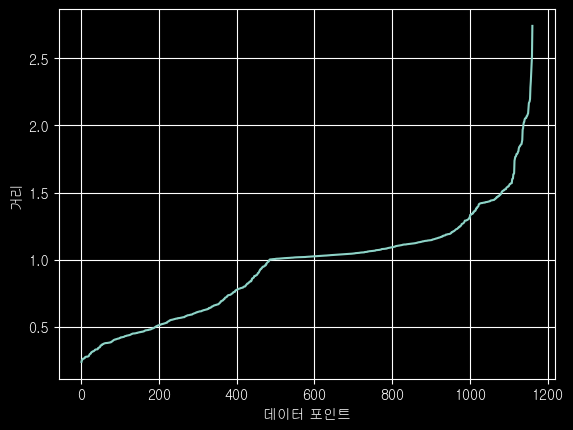

In [101]:
# k-dist plot 그려보기
plt.plot(distances)
plt.xlabel('데이터 포인트')
plt.ylabel('거리')
plt.grid()
plt.show()
# 엘보우 포인트 : 그래프에서 급격한 변화가 일어나는 지점을 선정
# eps : 1.0, 1.4에서 급격한 변화 보이는 것이 관측됨

In [102]:
# 모델 초기화
dbscan = DBSCAN(
    eps = 1.4,
    min_samples = (min_point + 1)
)
# 모델 학습
dbscan_cluster = dbscan.fit_predict(df_encoded)
pd.Series(dbscan_cluster).value_counts()

 0    233
 3    232
 1    230
 2    225
 4    182
-1     60
Name: count, dtype: int64

In [103]:
# 적절하게 설정되었다고 판단하고 label 추가
df_encoded['dbscan_cluster'] = dbscan_cluster
df_encoded.head(1)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month,요일_금,요일_목,요일_수,요일_월,요일_화,조식메뉴_Main_encoded,중식메뉴_Main_encoded,석식메뉴_Main_encoded,dbscan_cluster
0,0.0,0.022481,0.323442,0.227969,0.0,0.638865,0.283396,0.090909,False,False,False,True,False,1,1,3,2


In [104]:
# 노이즈 데이터 제거
df_clean = df[df_encoded['dbscan_cluster'] != -1]
df_encoded_clean = df_encoded[df_encoded['dbscan_cluster'] != -1]

In [105]:
# 클러스터링 재시도
dbscan = DBSCAN(
    eps = 1.4,
    min_samples = (min_point + 1)
)
dbscan_cluster_clean = dbscan.fit_predict(df_encoded_clean)

In [106]:
# 클러스터 분포 확인
pd.Series(dbscan_cluster_clean).value_counts()

0    233
3    232
1    230
2    225
4    182
Name: count, dtype: int64

In [107]:
# 클러스터별 데이터 추출 후 각각의 통계를 확인
cluster = {}
for cluster_num in range(5):
    cluster[cluster_num] = df_clean[dbscan_cluster_clean == cluster_num] # 각 군집별로 딕셔너리 형성

In [108]:
# 클러스터별 범주형 데이터 통계 확인
for cluster_num, data in cluster.items():
    print(f"클러스터 {cluster_num} 범주형 통계치")
    display(data.describe(include='object'))

클러스터 0 범주형 통계치


,요일,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
count,233,233,233,233
unique,1,186,223,210
top,목,삶은계란,카레감자채볶음,옛날왕돈까스
freq,233,5,3,3


클러스터 1 범주형 통계치


,요일,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
count,230,230,230,230
unique,1,181,212,213
top,금,재첩국,김구이,미니함박조림
freq,230,3,2,3


클러스터 2 범주형 통계치


,요일,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
count,225,225,225,225
unique,1,174,196,212
top,월,핫케익,야채계란찜,땅콩조림
freq,225,5,3,3


클러스터 3 범주형 통계치


,요일,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
count,232,232,232,232
unique,1,187,214,205
top,화,느타리볶음,김치찌개,고구마그라탕
freq,232,4,3,3


클러스터 4 범주형 통계치


,요일,조식메뉴_Main,중식메뉴_Main,석식메뉴_Main
count,182,182,182,182
unique,1,154,174,168
top,수,대구매운탕,산채비빔밥,근대국
freq,182,4,3,3


In [109]:
# 클러스터별 통계 요약
for cluster_num, data in cluster.items():
    print(f"클러스터 {cluster_num} 범주형 통계치")
    display(data.describe())

클러스터 0 범주형 통계치


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,2805.403433,136.133047,256.274678,381.412017,42.957082,821.218884,482.888412,6.467811
std,170.680763,133.928617,39.679015,145.573516,108.754183,124.377343,85.694855,3.439131
min,2601.000000,36.000000,41.000000,24.000000,0.000000,311.000000,117.000000,1.000000
25%,2645.000000,69.000000,241.000000,305.000000,0.000000,753.000000,443.000000,4.000000
50%,2760.000000,90.000000,265.000000,364.000000,0.000000,820.000000,489.000000,6.000000
75%,2962.000000,132.000000,282.000000,452.000000,0.000000,893.000000,531.000000,9.000000
max,3305.000000,1224.000000,315.000000,1017.000000,511.000000,1214.000000,743.000000,12.000000


클러스터 1 범주형 통계치


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,2811.617391,247.373913,273.613043,38.604348,39.060870,651.286957,406.604348,6.560870
std,173.726085,140.268081,33.061182,44.756351,96.741251,122.994498,97.418760,3.423938
min,2601.000000,83.000000,127.000000,0.000000,0.000000,387.000000,171.000000,1.000000
25%,2648.000000,165.250000,261.000000,1.000000,0.000000,570.500000,350.000000,4.000000
50%,2761.500000,200.000000,283.500000,40.500000,0.000000,644.000000,409.500000,7.000000
75%,2962.000000,263.250000,296.000000,60.750000,0.000000,722.000000,472.000000,9.000000
max,3305.000000,1026.000000,327.000000,428.000000,462.000000,1215.000000,755.000000,12.000000


클러스터 2 범주형 통계치


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,2809.537778,168.760000,203.968889,480.688889,47.262222,1150.035556,540.524444,6.493333
std,171.136327,168.708368,33.953801,181.380941,114.227911,166.827083,109.649973,3.479686
min,2601.000000,49.000000,53.000000,26.000000,0.000000,296.000000,104.000000,1.000000
25%,2645.000000,93.000000,190.000000,373.000000,0.000000,1103.000000,497.000000,3.000000
50%,2760.000000,112.000000,211.000000,475.000000,0.000000,1175.000000,552.000000,7.000000
75%,2962.000000,157.000000,226.000000,609.000000,0.000000,1246.000000,600.000000,10.000000
max,3305.000000,1113.000000,291.000000,941.000000,488.000000,1459.000000,772.000000,12.000000


클러스터 3 범주형 통계치


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,2803.793103,115.956897,230.525862,459.866379,48.349138,928.314655,521.594828,6.456897
std,167.890116,114.093521,40.392867,167.673963,120.690128,122.257978,97.804114,3.473816
min,2601.000000,31.000000,43.000000,51.000000,0.000000,462.000000,176.000000,1.000000
25%,2645.000000,61.000000,215.750000,361.500000,0.000000,847.000000,471.500000,3.000000
50%,2759.000000,73.000000,237.000000,437.500000,0.000000,920.000000,529.000000,7.000000
75%,2962.000000,112.000000,256.000000,558.750000,0.000000,994.000000,575.750000,9.000000
max,3305.000000,933.000000,378.000000,1035.000000,533.000000,1324.000000,902.000000,12.000000


클러스터 4 범주형 통계치


,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,month
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,2807.824176,112.291209,239.379121,9.978022,52.472527,913.631868,439.164835,6.494505
std,173.803953,103.272572,35.886164,82.698210,119.024798,127.534121,94.254301,3.364992
min,2601.000000,23.000000,56.000000,0.000000,0.000000,633.000000,123.000000,1.000000
25%,2645.000000,60.000000,225.000000,0.000000,0.000000,830.250000,379.750000,4.000000
50%,2759.000000,74.000000,245.000000,0.000000,0.000000,896.500000,426.000000,7.000000
75%,2962.000000,108.000000,262.750000,0.000000,0.000000,970.000000,491.500000,9.000000
max,3305.000000,490.000000,303.000000,1044.000000,479.000000,1336.000000,905.000000,12.000000


## 클러스터별 요약 & 재고 운영 가이드

| 클러스터 | 주요 특징                                                                                                  | 재고 관리 전략 |
|---|---|---|
| **클러스터 0** | • **시간외 근무 승인**이 많은 편(평균 상위권)  \| • **중식/석식 인원**도 비교적 **많음** | **중·석식 동시 강화**: 중식·석식 모두 충분히 확보  <br> **야근 대비**: 시간외 근무(연장/특근) 증가일에 대비해 비상 재고(간편식·음료) 소량 상시 보유 |
| **클러스터 1** | • **휴가자**가 **많음**(최상위)  \| • **시간외 근무 승인 매우 낮음**  \| • **출장자**도 높은 편 | **휴가·출장 시즌 절감**: 예상 수요 대비 **중식·석식 재고 축소**  <br> **당일 가변 발주**: 아침 집계(휴가·출장) 반영해 보수적으로 발주 |
| **클러스터 2** | • **중식 이용자 최다**(압도적 상위)  \| • **석식도 상위권**  \| • **시간외 근무 승인 많음** | **중식 최우선 강화**: 중식 재고 **최대치 확보**(피크 대비 초과분 확보 )  <br> **연장근무 대비**: 석식·야식 보강 및 탄력 배식(조기 소진 방지) |
| **클러스터 3** | • 전반적으로 **평균적**  \| 중식·석식·시간외 근무 승인 모두 **중간 수준** | 기본 발주량 유지  <br>  |
| **클러스터 4** | • **시간외 근무 승인 극소**(최저)  \| 중식·석식 **평균 이하** | **평균 재고 유지**: 과잉 최소화 중심  <br> **야근 최소 가정**: 비상 재고는 **최소 단위**만 유지 |

---

### 재고관리 방안
- **D-1 예측**: 휴가/출장/야근(명령서 승인 예정) 정보를 반영해 **클러스터별 기준 발주량**을 ±조정.
- **D-Day 오전 실사**: 방문 예약·출입 카운트·사내 회의 일정 반영, **중식 중심**으로 1차 조정.
- **오후 모니터링**: **시간외 근무 승인 급증 시** 석식/야식용 **간편식·음료 버퍼** 즉시 전개.
- **폐기 최소화**: 저감 대상(클러스터 1·4)의 **소포장·프리오더** 활용, 인기 품목 중심 **Fast/Slow 구분**으로 회전율 관리.

---

## 클러스터 → 지도학습 전환 아이디어

> 비지도 결과(클러스터 라벨)를 정답(라벨)으로 삼아 수요예측 분류/회귀 모델을 만들 수 있음   
> 예: 입력(휴가자수, 출장자수, 시간외근무 승인, 월 등) → 출력(클러스터 라벨 혹은 중식/석식 인원 구간).

### DBSCAN 특징
- 비선형 클러스터를 잘 찾아낼 수 있음
- Noise 데이터를 감지하고 삭제할 수 있음
- 클러스터의 모양과 크기에 관계없이 효과적으로 클러스터를 찾을 수 있음
- 하이퍼 파라미터 설정에 민감
- 데이터의 밀도가 크게 차이나는 경우, 클러스터링 결과가 좋지 않을 수 있음